In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
data_dir = '../data/data-alice-schrank-2'
data = {}
for idx, uuid in enumerate(os.scandir(data_dir)):
        
    # print(uuid.name)
    data[uuid.name] = {}
    data[uuid.name]['alice'] = {}
    data[uuid.name]['bob'] = {}
    for path, _, files in os.walk(os.path.join(data_dir, uuid.name)):
        if len(files) != 1:
            continue
        json = pd.read_json(os.path.join(path, files[0]), typ='series')
        json['csi'] = np.moveaxis(json['csi'], [0, 1, 2, 3], [2, 0, 1, 3])
        a = json['csi']
        b = np.reshape(a, (a.shape[0]*a.shape[1]*a.shape[2], a.shape[3]))
        c = np.array(list(map(lambda c: math.sqrt(c[0]**2 + c[1]**2), b)))
        json['csi_mag'] = np.reshape(c, (a.shape[0], a.shape[1], a.shape[2]))
        from_, to_ = path.split('/')[-2:]
        data[uuid.name][from_][to_] = json
print(len(data))

402


In [3]:
data_dir = '../data/data-alice-schrank-2'
timestamps = []

for idx, uuid in enumerate(os.scandir(data_dir)):
    for path, _, files in os.walk(os.path.join(data_dir, uuid.name)):
        if len(files) != 1:
            continue
        json = pd.read_json(os.path.join(path, files[0]), typ='series')
        from_, to_ = path.split('/')[-2:]
        if from_ == 'alice' and to_ == 'eve':
            timestamps.append(json['timestamp'])
            
print(max(timestamps) - min(timestamps))
print(list(map(lambda l: l[0] - l[1], zip(sorted(timestamps)[1:], sorted(timestamps)[:-1]))))

498235716
[2007691, 993297, 1000769, 1000155, 3005479, 998676, 3999608, 1000473, 1006527, 994571, 2000812, 1000499, 1000463, 1000735, 1000177, 2013811, 987598, 1000474, 3001680, 1017505, 996944, 2989386, 1002418, 996781, 1013278, 987633, 5002318, 1000754, 1000419, 1018545, 982686, 1002587, 998747, 1009612, 990406, 1000573, 1000439, 1002218, 1008466, 990688, 1003848, 1997509, 1002397, 999794, 2008361, 1005607, 986738, 1001155, 1002972, 997244, 1000513, 1002691, 998211, 1000472, 1001738, 999183, 2008250, 993677, 999982, 1000464, 1000511, 1003538, 1043988, 954197, 1000031, 1000495, 1000638, 2000762, 1006485, 995876, 1999592, 1000309, 1000465, 1001655, 3010710, 989897, 1000653, 1006370, 1994936, 1001837, 2002004, 1002985, 995424, 1005052, 998311, 1009809, 988608, 2000887, 1004095, 996819, 1000446, 1001340, 999587, 2002283, 1002546, 997380, 2000520, 1000453, 1000523, 1002934, 997922, 1000443, 1000449, 1000441, 1000446, 1000888, 1002457, 998607, 1001954, 999026, 1002938, 998583, 1001251, 998

# Channel Reciprocity Plot for Alice and Bob

In [4]:
keys = list(data.keys())

v = data[keys[100]]

In [5]:
recip = pd.DataFrame()
keys = list(data.keys())
MAG='Magnitude'
SUBI = 'Subcarrier Index'
for i in range(3):
    for j in range(3):
        json = {"key": "Alice ⇢ Bob", "TX": i, "RX": j}
        for idx, val in enumerate(v['alice']['bob']['csi_mag'][i][j]):
            json[SUBI] = idx
            json[MAG] = val
            recip = pd.concat([recip, pd.DataFrame([json])], ignore_index=True) 
        json = {"key": "Bob ⇢ Alice", "TX": i, "RX": j}
        for idx, val in enumerate(v['bob']['alice']['csi_mag'][i][j]):
            json[SUBI] = idx
            json[MAG] = val
            recip = pd.concat([recip, pd.DataFrame([json])], ignore_index=True)  
recip

,key,TX,RX,Subcarrier Index,Magnitude
0,Alice ⇢ Bob,0,0,0,58.180753
1,Alice ⇢ Bob,0,0,1,56.356011
2,Alice ⇢ Bob,0,0,2,61.611687
3,Alice ⇢ Bob,0,0,3,61.032778
4,Alice ⇢ Bob,0,0,4,58.523500
...,...,...,...,...,...
1003,Bob ⇢ Alice,2,2,51,161.987654
1004,Bob ⇢ Alice,2,2,52,158.218204
1005,Bob ⇢ Alice,2,2,53,165.556637
1006,Bob ⇢ Alice,2,2,54,151.092687


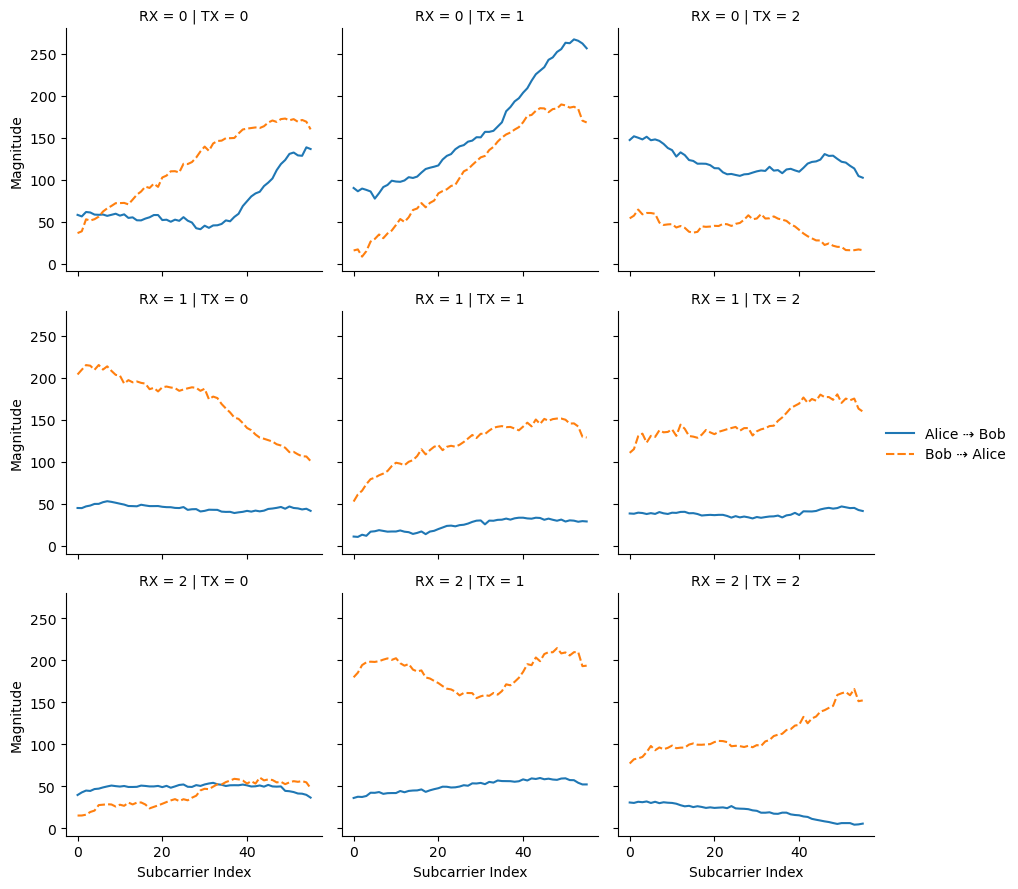

In [6]:
g = sns.FacetGrid(recip, col="TX", row="RX")
g.map_dataframe(sns.lineplot, x=SUBI, y=MAG, hue='key', style='key')
g.add_legend()

plt.savefig('recip.pdf', bbox_inches='tight')

# Calculate P-Values for each TX-RX antenna pair and measurement

In [7]:
pvalues = pd.DataFrame()
keys = list(data.keys())

for key in keys:
    v = data[key]
    for i in range(3):
        for j in range(3):
            a = v['alice']['bob']['csi_mag'][i][j]
            b = v['bob']['alice']['csi_mag'][i][j]
            results = scipy.stats.pearsonr(a, b, alternative='two-sided')
            pvalues = pd.concat([pvalues, pd.DataFrame([{"TX": i, "RX": j, "pvalue": results.pvalue}])], ignore_index=True)

pvalues

,TX,RX,pvalue
0,0,0,2.505706e-10
1,0,1,3.649763e-15
2,0,2,2.151963e-04
3,1,0,8.840384e-33
4,1,1,1.074506e-20
...,...,...,...
3613,1,1,1.202381e-33
3614,1,2,1.020799e-01
3615,2,0,1.133219e-03
3616,2,1,4.597535e-07


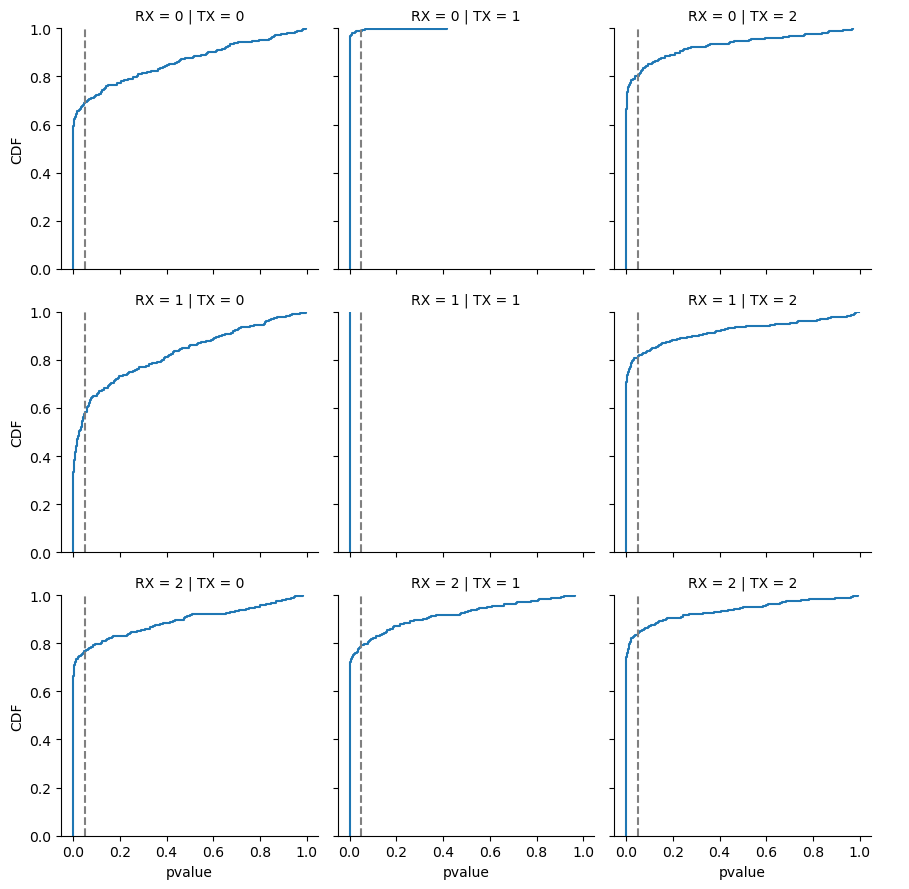

In [8]:
g = sns.FacetGrid(pvalues, col="TX", row="RX")
g.map_dataframe(sns.ecdfplot, "pvalue")
g.add_legend()
g.refline(x=0.05)
g.set_ylabels('CDF')

plt.savefig('recip-pvalues.pdf', bbox_inches='tight')

In [9]:
## tested out how to transform matricise and calculate magnitude from complex values

a = np.array([
    [
        [ [ 1, 2], [3, 4], [5, 6] ],
        [ [ 7, 8], [9, 10], [11, 12] ],
    ],
    [
        [ [ 1, 2], [3, 4], [5, 6] ],
        [ [ 7, 8], [99, 10], [11, 12] ],
    ],
    [
        [ [ 1, 2], [3, 4], [5, 6] ],
        [ [ 7, 8], [9, 10], [21, 12] ],
    ]
])
print(a.shape)
b = np.reshape(a, (a.shape[0]*a.shape[1]*a.shape[2], a.shape[3]))
c = np.array(list(map(lambda c: math.sqrt(c[0]**2 + c[1]**2), b)))
np.reshape(c, (a.shape[0], a.shape[1], a.shape[2]))

(3, 2, 3, 2)


array([[[ 2.23606798,  5.        ,  7.81024968],
        [10.63014581, 13.45362405, 16.2788206 ]],

       [[ 2.23606798,  5.        ,  7.81024968],
        [10.63014581, 99.50376877, 16.2788206 ]],

       [[ 2.23606798,  5.        ,  7.81024968],
        [10.63014581, 13.45362405, 24.18677324]]])